# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [2]:
%pip install --user sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer

In [4]:
import tensorflow

tensorflow.keras.datasets.fashion_mnist
# tensorflow.__version__

<module 'keras.api._v2.keras.datasets.fashion_mnist' from 'c:\\Users\\Настя\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\keras\\api\\_v2\\keras\\datasets\\fashion_mnist\\__init__.py'>

In [6]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

In [7]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [8]:
# сам прекрасный класс

from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', use_subset=False):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.use_subset = use_subset

        # self.w = np.random.randn(self.n_features, self.new_dim)
        self.w = None
        self.b = np.random.uniform(-np.pi, np.pi, size=(1, self.n_features))
        self.sigma_squared = None
        self.norm = Normalizer(norm='l2')
        self.pca = PCA(n_components=self.new_dim)
         # сгенерировали n_features наборов w_j и b_j


    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """

        if self.use_PCA:
            # pca = PCA(n_components=self.new_dim)
            X_norm = self.norm.fit_transform(X)
            X_pca = self.pca.fit_transform(X_norm)
            # X_pca = self.pca.fit_transform(X)
        else:
            X_pca = X

        num_objects = X_pca.shape[0]
        num_samples = 1000000
        indices = np.random.choice(num_objects, size=(num_samples, 2))
        indices = indices[indices[:,0] != indices[:,1]]
        self.sigma_squared = np.median(np.sum((X_pca[indices[:, 0]] - X_pca[indices[:, 1]])**2, axis=1))
        # оценили гиперпараметр сигма в квадрате

        self.w = np.random.normal(loc=0, scale=1/np.sqrt(self.sigma_squared), size=(self.n_features, self.new_dim))
        # отнормировали w_j

        X_approx = np.cos(np.dot(X_pca, self.w.T) + self.b)
        # сформировали n_features новых признаков по формуле аппроксимации ядра

        if self.classifier == 'logreg':
            self.model = LogisticRegression().fit(X_approx, y)
        elif self.classifier == 'svm':
            self.model = SVC().fit(X_approx, y)
        elif self.classifier == 'svm_rbf':
            if self.use_subset:
                subset_indices = np.random.choice(X_approx.shape[0], size=25000, replace=False)
                X_subset = X_approx[subset_indices]
                y_subset = y[subset_indices]
                self.model = SVC(kernel='rbf').fit(X_subset, y_subset)
            else:
                self.model = SVC(kernel='rbf').fit(X_approx, y)
        else:
            raise NotImplementedError

        return self.model


    def transform(self, X):
        """
        Transform test set (PCA, RFF).
        """
        if self.use_PCA:
            # pca = PCA(n_components=self.new_dim)
            X_norm = self.norm.transform(X)
            X_pca = self.pca.transform(X_norm)
            # X_pca = self.pca.transform(X)
        else:
            X_pca = X

        X_approx = np.cos(np.dot(X_pca, self.w.T) + self.b)
        return X_approx


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_approx = self.transform(X)
        return self.model.predict_proba(X_approx)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_approx = self.transform(X)
        return self.model.predict(X_approx)

In [6]:
pipeline = RFFPipeline()
# print(pipeline.sigma_squared)
pipeline.fit(x_train, y_train)
# print(pipeline.sigma_squared)

c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
y_pred = pipeline.predict(x_test)
# print(pipeline.sigma_squared)
# print(y_pred)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8601


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

#### __1. Случайные признаки VS исходные признаки, SVM__

-1. logreg, исходные признаки

In [9]:
logreg = LogisticRegression().fit(x_train, y_train)

c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
y_pred_logreg = logreg.predict(x_test)

In [11]:
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy_logreg)

Accuracy: 0.8412


0. SVM, исходные признаки

In [12]:
svm = SVC().fit(x_train, y_train)

In [14]:
y_pred_without_rff = svm.predict(x_test)

In [15]:
accuracy_without_rff = accuracy_score(y_test, y_pred_without_rff)
print("Accuracy:", accuracy_without_rff)

Accuracy: 0.8828


1. SVM, случайные признаки

In [16]:
pipeline_svm = RFFPipeline(classifier='svm')
pipeline_svm.fit(x_train, y_train)

SVC()

In [17]:
y_pred_svm = pipeline_svm.predict(x_test)

In [18]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

Accuracy: 0.8681


2. Ядрововой SVM, случайные признаки (на подвыборке в 25000 наблюдений)

In [31]:
pipeline_svm_rbf = RFFPipeline(classifier='svm_rbf', use_subset=True)
pipeline_svm_rbf.fit(x_train, y_train)

SVC()

In [32]:
y_pred_svm_rbf = pipeline_svm_rbf.predict(x_test)

In [33]:
accuracy_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
print("Accuracy:", accuracy_svm_rbf)

Accuracy: 0.8589


3. Ядрововой SVM, случайные признаки (на полной выборке наблюдений)

In [47]:
pipeline_svm_rbf_full = RFFPipeline(classifier='svm_rbf')
pipeline_svm_rbf_full.fit(x_train, y_train)

SVC()

In [48]:
y_pred_svm_rbf_full = pipeline_svm_rbf_full.predict(x_test)

In [49]:
accuracy_svm_rbf_full = accuracy_score(y_test, y_pred_svm_rbf_full)
print("Accuracy:", accuracy_svm_rbf_full)

Accuracy: 0.8677


#### __2. Случайные признаки VS понижение размерности МГК и градинтный бустинг__

In [25]:
pca = PCA(n_components=50)
X_pca_train = pca.fit_transform(x_train)
X_pca_test = pca.transform(x_test)

In [26]:
catboost_model = CatBoostClassifier(iterations=200, learning_rate=0.03, depth=6, random_seed=42)
catboost_model.fit(X_pca_train, y_train, verbose=False);

In [27]:
y_pred_cat = catboost_model.predict(X_pca_test)

In [28]:
accuracy_cat = accuracy_score(y_test, y_pred_cat)

In [29]:
print("Accuracy_gb:", accuracy_cat)
print("Accuracy_rff_logreg:", accuracy)
print("Accuracy_rff_svm:", accuracy_svm)

Accuracy_gb: 0.8112
Accuracy_rff_logreg: 0.8601
Accuracy_rff_svm: 0.8681


#### __3. Выводы к заданию 2__

1. Сравнение по качеству модели:

- Обучение модели на случайных признаках с помощью RFF работает, но не во всех рассмотренных ранее случаях выдаёт лучшее качество по сравнению с моделям, обученными на исходных признаках. Например, свм на случайных признаках сработал хуже (метод опорных векторов на исходных признаках в целом выдал лучший результат -- 0.88). Обычный метод опорных векторов превзошёл модель на ядровом свм на подвыборке, но выдал примерно то же качество, что ядровой свм на полной выборке. SVM, обученные на случайных признаках, могут уступать по качеству SVM на исходных, например, потому, что при проекции в более высокое пространство мы можем потерять часть информации об исходных данных, из-за коррелированности созданных признаков и т.д. Градиентный бустинг с указанными параметрами покаазал неплохой результат, но он оказался ниже, чем у остальных.

2. Сравнение по скорости обучения:

- В случае с логистической регрессией, модель на исходных признаках обучается побыстрее, но разница по времени совсем небольшая. Все логистические регрессии обучаются быстрее любой вариации метода опорных векторов. Что касается различий по времени между разными вариациями svm, здесь разница в обучении заметнее. Дольше всего обучается ядровой svm, но его вариация, обученная на подвыборке наблюдений, фитится значительно меньше времени, чем свм на случайных и на исходных признаках.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

##### __1. Предварительное понижение размерности с помощью МГК__

In [44]:
# pca = PCA(n_components=50)
# X_pca_train = pca.fit_transform(x_train)
# X_pca_test = pca.transform(x_test)

In [34]:
norm = Normalizer(norm='l2')
X_norm_train = norm.fit_transform(x_train)
X_norm_test = norm.transform(x_test)

pca = PCA(n_components=50)
X_pca_train = pca.fit_transform(X_norm_train)
X_pca_test = pca.transform(X_norm_test)
# print(X_pca_test.shape)

Для начала посмотрим на __логистической регрессии__.

In [35]:
logreg_pca = RFFPipeline(use_PCA=False)
logreg_pca.fit(X_pca_train, y_train)
# print(logreg_pca.w.T.shape)

c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
y_pred_logreg_pca = logreg_pca.predict(X_pca_test)
accuracy_logreg_pca = accuracy_score(y_test, y_pred_logreg_pca)

In [37]:
print("Accuracy current:", accuracy_logreg_pca)
print("Accuracy previous:", accuracy)

Accuracy current: 0.8597
Accuracy previous: 0.8601


__Вывод: предварительное понижение размерности мгк для логистической регресии не несёт в себе эффективности.__

Теперь посмотрим на __методе опорных векторов__.

In [38]:
norm = Normalizer(norm='l2')
X_norm_train = norm.fit_transform(x_train)
X_norm_test = norm.transform(x_test)

pca = PCA(n_components=50)
X_pca_train = pca.fit_transform(X_norm_train)
X_pca_test = pca.transform(X_norm_test)

In [39]:
svm_pca = RFFPipeline(use_PCA=False, classifier='svm')
svm_pca.fit(X_pca_train, y_train)

SVC()

In [40]:
y_pred_svm_pca = svm_pca.predict(X_pca_test)
accuracy_svm_pca = accuracy_score(y_test, y_pred_svm_pca)

In [41]:
print("Accuracy current:", accuracy_svm_pca)
print("Accuracy previous:", accuracy_svm)

Accuracy current: 0.8675
Accuracy previous: 0.8681


__Вывод: качество модели после предварительного понижения размерности незначительно ухудшилось, эффективости нет.__

А что с __ядровым SVM__?

In [43]:
norm = Normalizer(norm='l2')
X_norm_train = norm.fit_transform(x_train)
X_norm_test = norm.transform(x_test)

pca = PCA(n_components=50)
X_pca_train = pca.fit_transform(X_norm_train)
X_pca_test = pca.transform(X_norm_test)

In [44]:
svm_pca_kernel = RFFPipeline(use_PCA=False, classifier='svm_rbf', use_subset=True)
svm_pca_kernel.fit(X_pca_train, y_train)

SVC()

In [45]:
y_pred_svm_pca_kernel = svm_pca_kernel.predict(X_pca_test)
accuracy_svm_pca_kernel = accuracy_score(y_test, y_pred_svm_pca_kernel)

In [46]:
print("Accuracy current:", accuracy_svm_pca_kernel)
print("Accuracy previous:", accuracy_svm_rbf)

Accuracy current: 0.8588
Accuracy previous: 0.8589


__Вывод: качество почти не изменилось, а время на обучение заметно сократилось, можно применять.__

##### __2. Зависимость качества модели от количества переменных__

Посмотрим при базовых гиперпараметрах (логистическая регрессия), так как модель обучается быстрее всего и не сильно уступает свм по качеству.

In [50]:
n_features_values = [10, 50, 100, 500, 1000, 1500, 2000, 3500, 5000, 10000]
quality_scores = []

for i in n_features_values:
    model = RFFPipeline(n_features=i)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    quality_scores.append(accuracy)
    print(f"Accuracy: {i}:", accuracy)

c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 10: 0.6272


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 50: 0.8136


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 100: 0.8397


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 500: 0.8574


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 1000: 0.8621


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 1500: 0.865


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 2000: 0.8625


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 3500: 0.8623


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 5000: 0.8614


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 10000: 0.8633


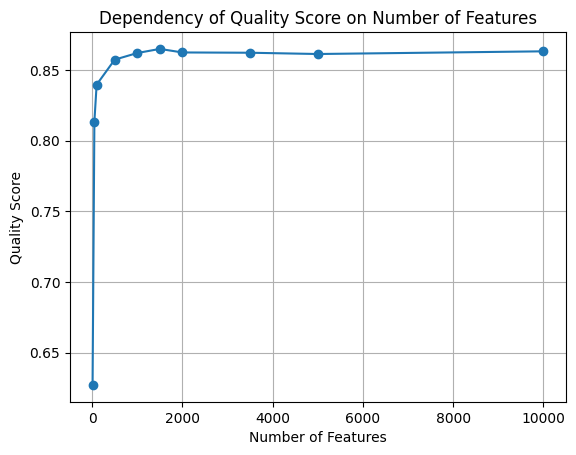

In [51]:
plt.plot(n_features_values, quality_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Quality Score')
plt.title('Dependency of Quality Score on Number of Features')
plt.grid(True)
plt.show()

__Вывод: как мы можем заметить, итоговое качество зависит от количества случайных признаков, но после достижения определёного значения количества признаков, качество модели выходит на плато и колеблется в примерно одном и том же диапазоне значений.__

##### __3. Логистическая регрессия или SVM?__

В нашей задаче обучение на логистичекой регрессии представляется лучшим вариантом (если мы обязательно работает в рамках созданного класса со случайными признаками, на исходных признаках лучший результат выдал svm и стоило бы использовать его), так как качество незначительно уступает методу опорных векторов, а затраты на фит логистической регрессии значительно меньше. Однако это касается только нашей конкретной задачи, в целом выбор между свм и логрег достаточно важен. Логистическая регрессия также эффективна при наличии большого количества признаков и небольшого объема данных. В это время СВМ лучше работает со сложными данными. 

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [52]:
class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', use_subset=False):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.use_subset = use_subset

        # self.w = np.random.randn(self.n_features, self.new_dim)
        self.w = None
        self.b = np.random.uniform(-np.pi, np.pi, size=(1, self.n_features))
        self.sigma_squared = None
        self.norm = Normalizer(norm='l2')
        self.pca = PCA(n_components=self.new_dim)
         # сгенерировали n_features наборов w_j и b_j


    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """

        if self.use_PCA:
            X_norm = self.norm.fit_transform(X)
            X_pca = self.pca.fit_transform(X_norm)
        else:
            X_pca = X

        num_objects = X_pca.shape[0]
        num_samples = 1000000
        indices = np.random.choice(num_objects, size=(num_samples, 2))
        indices = indices[indices[:,0] != indices[:,1]]
        self.sigma_squared = np.median(np.sum((X_pca[indices[:, 0]] - X_pca[indices[:, 1]])**2, axis=1))

        w = np.random.normal(loc=0, scale=1/np.sqrt(self.sigma_squared), size=(self.n_features, self.new_dim))

        self.w, _ = np.linalg.qr(w)
        # QR-разложение, сохраняем в self.w ортогональную матрицу
        self.w = self.w[:, :self.new_dim]
        # используем только первые new_dim столбцов, чтобы класс умел работать со случаем n_features > new_dim

        X_approx = np.cos(np.dot(X_pca, self.w.T) + self.b)

        if self.classifier == 'logreg':
            self.model = LogisticRegression().fit(X_approx, y)
        elif self.classifier == 'svm':
            self.model = SVC().fit(X_approx, y)
        elif self.classifier == 'svm_rbf':
            if self.use_subset:
                subset_indices = np.random.choice(X_approx.shape[0], size=20000, replace=False)
                X_subset = X_approx[subset_indices]
                y_subset = y[subset_indices]
                self.model = SVC(kernel='rbf').fit(X_subset, y_subset)
            else:
                self.model = SVC(kernel='rbf').fit(X_approx, y)
        else:
            raise NotImplementedError

        return self.model


    def transform(self, X):
        """
        Transform test set (PCA, RFF).
        """
        if self.use_PCA:
            # pca = PCA(n_components=self.new_dim)
            X_norm = self.norm.transform(X)
            X_pca = self.pca.transform(X_norm)
            # X_pca = self.pca.transform(X)
        else:
            X_pca = X

        X_approx = np.cos(np.dot(X_pca, self.w.T) + self.b)
        return X_approx


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_approx = self.transform(X)
        return self.model.predict_proba(X_approx)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_approx = self.transform(X)
        return self.model.predict(X_approx)

In [53]:
orf_pipeline = ORFPipeline()
print(orf_pipeline.w)
orf_pipeline.fit(x_train, y_train)
print(orf_pipeline.w.shape)

None
(1000, 50)


c:\Users\Настя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
y_pred = orf_pipeline.predict(x_test)

In [55]:
accuracy_orf = accuracy_score(y_test, y_pred)
print("Accuracy ORF:", accuracy_orf)
print("Accuracy RFF:", accuracy)

Accuracy ORF: 0.7984
Accuracy RFF: 0.8633


Посмотрим на свм.

In [56]:
# эта ячейка выполняется бесконечное количество времени

# orf_pipeline_svm = ORFPipeline(classifier='svm')
# orf_pipeline_svm.fit(x_train, y_train)

In [ ]:
y_pred_svm_orf = orf_pipeline_svm.predict(x_test)

accuracy_svm_orf = accuracy_score(y_test, y_pred_svm_orf)
print("Accuracy ORF:", accuracy_svm_orf)
print("Accuracy RFF:", accuracy_svm)

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# сам прекрасный класс

from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', use_subset=False):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.use_subset = use_subset

        self.w = None
        self.b = np.random.uniform(-np.pi, np.pi, size=(1, self.n_features))
        self.sigma_squared = None
        self.norm = Normalizer(norm='l2')
        self.pca = PCA(n_components=self.new_dim)
         # сгенерировали n_features наборов w_j и b_j


    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """

        if self.use_PCA:
            X_norm = self.norm.fit_transform(X)
            X_pca = self.pca.fit_transform(X_norm)
        else:
            X_pca = X

        num_objects = X_pca.shape[0]
        num_samples = 1000000
        indices = np.random.choice(num_objects, size=(num_samples, 2))
        indices = indices[indices[:,0] != indices[:,1]]
        self.sigma_squared = np.median(np.sum((X_pca[indices[:, 0]] - X_pca[indices[:, 1]])**2, axis=1))
        # оценили гиперпараметр сигма в квадрате

        self.w = np.random.normal(loc=0, scale=1/np.sqrt(self.sigma_squared), size=(self.n_features, self.new_dim))
        # отнормировали w_j

        X_approx = np.cos(np.dot(X_pca, self.w.T) + self.b)
        # сформировали n_features новых признаков по формуле аппроксимации ядра

        if self.classifier == 'logreg':
            self.model = LogisticRegression().fit(X_approx, y)
        elif self.classifier == 'svm':
            self.model = SVC().fit(X_approx, y)
        elif self.classifier == 'svm_rbf':
            if self.use_subset:
                subset_indices = np.random.choice(X_approx.shape[0], size=25000, replace=False)
                X_subset = X_approx[subset_indices]
                y_subset = y[subset_indices]
                self.model = SVC(kernel='rbf').fit(X_subset, y_subset)
            else:
                self.model = SVC(kernel='rbf').fit(X_approx, y)
        else:
            raise NotImplementedError

        return self.model


    def transform(self, X):
        """
        Transform test set (PCA, RFF).
        """
        if self.use_PCA:
            X_norm = self.norm.transform(X)
            X_pca = self.pca.transform(X_norm)
        else:
            X_pca = X

        X_approx = np.cos(np.dot(X_pca, self.w.T) + self.b)
        return X_approx


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_approx = self.transform(X)
        return self.model.predict_proba(X_approx)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_approx = self.transform(X)
        return self.model.predict(X_approx)

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError